# 基于卷积神经网络的脑电运动成像信号分类
## 数据集
数据来自8个健康的受试者（训练受试者S1～S4，测试受试者S5～S8），每一个受试者执行两类运动想象任务：右手和双脚，脑电信号由一个13通道的脑电帽以512Hz的频率记录得到。我们提供了经过预处理后的数据：下采样到了250Hz，带通滤波至8-32Hz，划分每一次视觉提示出现后的0.5~3.5s之间的EEG信号作为一个trial。每个用户包含200个trial（右手和双脚各100个trial）。
数据以.npz和.mat格式提供，包含：
* X: 预处理后的EEG信号, 维度: [trails * 通道* 采样点]。
* y: 类别标签向量。测试数据不包含此变量。

In [178]:
# Read in Data
import numpy as np

datafile1 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S1.npz"
datafile2 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S2.npz"
datafile3 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S3.npz"
datafile4 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S4.npz"

dataSet1 = np.load(datafile1)
dataSet2 = np.load(datafile2)
dataSet3 = np.load(datafile3)
dataSet4 = np.load(datafile4)


In [179]:
data_X = np.concatenate([dataSet1['X'], dataSet2['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet3['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet4['X']], axis = 0)

print('====== Dataset Train S1~S4 -> X ======')
print('Type:', type(data_X))
print('Dimision:', data_X.ndim)
print('Shape:', data_X.shape)

====== Dataset Train S1~S4 -> X ======
Type: <class 'numpy.ndarray'>
Dimision: 3
Shape: (800, 13, 750)


In [180]:
data_y = np.concatenate([dataSet1['y'], dataSet2['y']],                 axis = 0)

data_y = np.concatenate([data_y, dataSet3['y']],                 axis = 0)

data_y = np.concatenate([data_y, dataSet4['y']],                 axis = 0)


print('===== Dataset Train S1~S4 -> Lable(y) =====')
# lableTrain = np.reshape(lableTrain, (1, 800))
# print(lableTrain)

print('Type:', type(data_y))
print('Dimision:', data_y.ndim)
print('Shape:', data_y.shape)

===== Dataset Train S1~S4 -> Lable(y) =====
Type: <class 'numpy.ndarray'>
Dimision: 1
Shape: (800,)


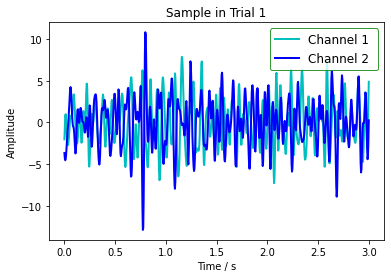

In [181]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

sampleRate = 250 # Sample Rate = 250Hz

# X Axis
t = np.linspace(0, data_X.shape[2] / sampleRate, data_X.shape[2])

# Sample Line
L1 = data_X[0, 0, :]
L2 = data_X[1, 0, :]

# Plot
plt.style.use('seaborn-colorblind')
plt.title("Sample in Trial 1")
plt.xlabel('Time / s')
plt.ylabel('Amplitude') # 振幅

plt.plot(t, L1, 'c-', linewidth= 2, label='Channel 1 ')
plt.plot(t, L2, 'b-', linewidth = 2, label='Channel 2')

plt.legend(loc='upper right',fontsize='large',frameon=True,edgecolor='green')

In [182]:
# # Using a Slide Window to process EEG Multichannel Time Series
# # Parameters:
# #   data:       Input Dataset
# #   sw_width:   Window Width
# #   in_start:   Start Point
# #   Step
#
# def slide_window(data_x, data_y, sw_width = 7, in_start = 0, step = 1):
#
#     X, y = [], []
#
#     for _ in range(len(data_x)):
#         in_end = in_start + sw_width # 0 + 7
#         out_end = in_end + sw_width
#
#         # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
#         if out_end < len(data_x):
#
#             X.append(data_x[:, :, in_start:in_end])
#             y.append(data_y[in_start:in_end])
#
#         in_start += step
#
#     return np.array(X), np.array(y)
#
# slide_X, slide_y = slide_window(data_X, data_y)
# print('====== Slide Window Process X ======')
# print('Type:', type(slide_X))
# print('Dimision:', slide_X.ndim)
# print('Shape:', slide_X.shape)
# print(' ')
# print('====== Slide Window Process Y ======')
# print('Type:', type(slide_y))
# print('Dimision:', slide_y.ndim)
# print('Shape:', slide_y.shape)

In [183]:
## CNN Model

import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam

# train_x, train_y = slide_window(data_X, data_y)

data_X = data_X.transpose(0, 2, 1) # Transpose data_X into [batch, Time_Peroids, channel]
# print(data_X.shape) # (800, 750, 13)
input_shape = data_X.shape[1], data_X.shape[2] # (750, 13)

print('Input Shape:', input_shape)

model = Sequential()

model.add(Conv1D(filters = 16, kernel_size = 10, activation='relu', input_shape = input_shape))

model.add(Conv1D(16, 10, activation='relu'))

model.add(MaxPooling1D(3))

model.add(Conv1D(32, 10, activation='relu'))

model.add(Conv1D(32, 10, activation='relu'))

model.add(MaxPooling1D(3))

model.add(Conv1D(32, 10, activation='relu'))

model.add(GlobalAveragePooling1D())

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # Dense(num_classes)

print(model.summary())

# model.add(MaxPooling1D(pool_size=2))
#
# model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
#
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(units=1))
#
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
#
# model.fit(data_X, data_y,
#           epochs = 20, batch_size = 50, verbose = 2)

Input Shape: (750, 13)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_103 (Conv1D)         (None, 741, 16)           2096      
                                                                 
 conv1d_104 (Conv1D)         (None, 732, 16)           2576      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 244, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_105 (Conv1D)         (None, 235, 32)           5152      
                                                                 
 conv1d_106 (Conv1D)         (None, 226, 32)           10272     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 75, 32)           0         
 g1D)                         

In [184]:
# CNN Model

import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D
from keras.optimizers import Adam

# train_x, train_y = slide_window(data_X, data_y)
#
# input_shape = data_X.shape[1], data_X.shape[2] # (13, 750)



In [185]:
# # Building CNN Model
# # Multi-input channel CNN model
#
# model = Sequential()
#
# model.add(Conv2D(16, (4,4), padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', name = 'conv2d_1'))
# model.add(Activation('relu',name = 'activation_1'))
# model.add(MaxPool2D(pool_size=(8,8),name = 'maxpool2d_1'))
# model.add(Dropout(0.25,name = 'dropout_1'))
#
# model.add(Conv2D(32, (4,4), padding = 'same',kernel_initializer = 'he_normal', name = 'conv2d_2'))
# model.add(Activation('relu',name = 'activation_2'))
# model.add(MaxPool2D(pool_size=(2,2),name = 'maxpool2d_2'))
# model.add(Dropout(0.25,name = 'dropout_2'))
#
# model.add(Flatten(name = 'flatten_1'))
# model.add(Dense(240,kernel_initializer='he_normal',name='dense_1'))
# model.add(Activation('relu',name='activation_3'))
# model.add(Dropout(0.5,name = 'dropout_3'))
# model.add(Dense(num_classes, kernel_initializer='he_normal',name='dense_2'))
# model.add(Activation('softmax',name='activation_4'))
# model.summary()
#
# # 优化方法
# opt = keras.optimizers.Adam(lr=0.0003, decay = 1e-6)
# # 编译模型
# model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])